In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from Chempy.parameter import ModelParameters

import sbi.utils as utils
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

import time as t
import pickle

/Users/bguenes/miniconda3/envs/master_chempy_multi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load the data

In [2]:
# ------ Load & prepare the data ------

# --- Load in training data ---
path_training = '../ChempyMulti/tutorial_data/TNG_Training_Data.npz'
training_data = np.load(path_training, mmap_mode='r')

elements = training_data['elements']
train_x = training_data['params']
train_y = training_data['abundances']


# ---  Load in the validation data ---
path_test = '../ChempyMulti/tutorial_data/TNG_Test_Data.npz'
val_data = np.load(path_test, mmap_mode='r')

val_x = val_data['params']
val_y = val_data['abundances']


# --- Clean the data ---
# Chempy sometimes returns zeros or infinite values, which need to removed
def clean_data(x, y):
    # Remove all zeros from the training data
    index = np.where((y == 0).all(axis=1))[0]
    x = np.delete(x, index, axis=0)
    y = np.delete(y, index, axis=0)

    # Remove all infinite values from the training data
    index = np.where(np.isfinite(y).all(axis=1))[0]
    x = x[index]
    y = y[index]

    return x, y


train_x, train_y = clean_data(train_x, train_y)
val_x, val_y     = clean_data(val_x, val_y)

# convert to torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
val_x = torch.tensor(val_x, dtype=torch.float32)
val_y = torch.tensor(val_y, dtype=torch.float32)

In [3]:
a = ModelParameters()
labels = [a.to_optimize[i] for i in range(len(a.to_optimize))] + ['time']
priors = torch.tensor([[a.priors[opt][0], a.priors[opt][1]] for opt in a.to_optimize])

# Define the NN

In [4]:
if torch.backends.mps.is_available():
    print("using mps")
    device = torch.device("cpu")
else:
    print("using cpu")
    device = torch.device("cpu")


class Model_Torch(torch.nn.Module):
    def __init__(self):
        super(Model_Torch, self).__init__()
        self.l1 = torch.nn.Linear(train_x.shape[1], 100)
        self.l2 = torch.nn.Linear(100, 40)
        self.l3 = torch.nn.Linear(40, train_y.shape[1])

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.l2(x))
        x = self.l3(x)
        return x

model = Model_Torch()
model.to(device);

using mps


# Train the model

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# shuffle the data
index = np.arange(train_x.shape[0])
np.random.shuffle(index)
train_x = train_x[index]
train_y = train_y[index]

# --- Train the neural network ---
epochs = 15
batch_size = 64
ep_loss = []
start = t.time()
for epoch in range(epochs):
    start_epoch = t.time()
    train_loss = []
    for i in range(0, train_x.shape[0], batch_size):
        optimizer.zero_grad()
        
        # Get the batch
        x_batch = train_x[i:i+batch_size].to(device)
        y_batch = train_y[i:i+batch_size].to(device)
        
        # Forward pass
        y_pred = model(x_batch)

        # Compute Loss
        loss = loss_fn(y_pred, y_batch)
        train_loss.append(loss.item())
        
        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        
    # Validation loss
    y_pred = model(val_x)
    val_loss = loss_fn(y_pred, val_y)
    
    train_loss = np.array(train_loss).mean()
    ep_loss.append([train_loss, val_loss.item()])
        
    end_epoch = t.time()
    epoch_time = end_epoch - start_epoch
    
    print(f'Epoch {epoch+1}/{epochs} in {round(epoch_time,1)}s, Loss: {round(train_loss,6)} | Val Loss: {round(val_loss.item(),6)}')
print(f'Training finished | Total time: {round(end_epoch - start, 1)}s')

Epoch 1/15 in 2.1s, Loss: 0.005347 | Val Loss: 0.00177
Epoch 2/15 in 2.6s, Loss: 0.001049 | Val Loss: 0.001069
Epoch 3/15 in 2.4s, Loss: 0.000695 | Val Loss: 0.000872
Epoch 4/15 in 2.3s, Loss: 0.000534 | Val Loss: 0.000402
Epoch 5/15 in 2.3s, Loss: 0.000439 | Val Loss: 0.000326
Epoch 6/15 in 2.3s, Loss: 0.000389 | Val Loss: 0.000299
Epoch 7/15 in 2.3s, Loss: 0.000357 | Val Loss: 0.000283
Epoch 8/15 in 2.3s, Loss: 0.000335 | Val Loss: 0.000275
Epoch 9/15 in 2.3s, Loss: 0.000318 | Val Loss: 0.000268
Epoch 10/15 in 2.4s, Loss: 0.000304 | Val Loss: 0.000262
Epoch 11/15 in 2.3s, Loss: 0.000293 | Val Loss: 0.000255
Epoch 12/15 in 2.3s, Loss: 0.000283 | Val Loss: 0.000247
Epoch 13/15 in 2.3s, Loss: 0.000274 | Val Loss: 0.000239
Epoch 14/15 in 2.3s, Loss: 0.000267 | Val Loss: 0.000232
Epoch 15/15 in 2.3s, Loss: 0.00026 | Val Loss: 0.000225
Training finished | Total time: 34.8s


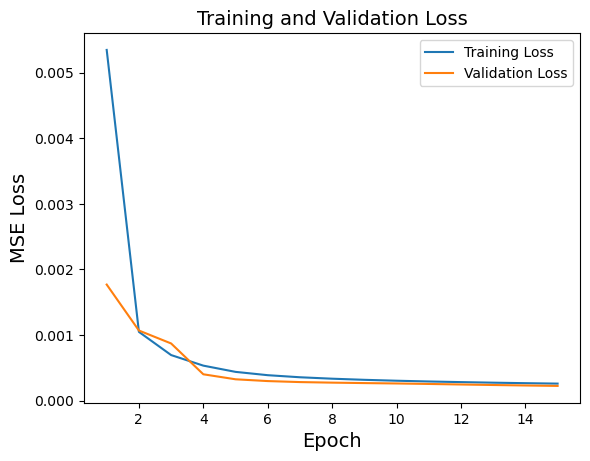

In [6]:
ep_loss = np.array(ep_loss)

plt.plot(np.arange(epochs)+1, ep_loss[:,0], label='Training Loss')
plt.plot(np.arange(epochs)+1, ep_loss[:,1], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.show()

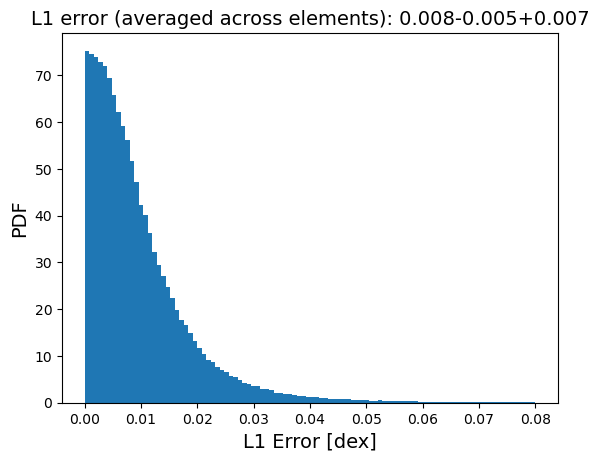

In [7]:
# --- Calculate the L1 error ---
l1_err = np.abs(model(val_x).detach().numpy() - val_y.numpy())
p1,p2,p3=np.percentile(l1_err,[15.865,50.,100-17.865],axis=0).mean(axis=1)

plt.hist(l1_err.flatten(), range=[0,.08], bins=100, density=True)
plt.xlabel(r'L1 Error [dex]', fontsize=14)
plt.ylabel(r'PDF', fontsize=14)

plt.title(r'L1 error (averaged across elements): %.3f-%.3f+%.3f'%(p2,p2-p1,p3-p2), fontsize=14)
plt.show()

In [ ]:
# --- Save the model ---
torch.save(model.state_dict(), 'data/pytorch_state_dict.pt')

# Train SBI

In [ ]:
# --- Load the model ---
model = Model_Torch()
model.load_state_dict(torch.load('data/pytorch_state_dict.pt'))
model.to(device)
model.eval();

In [8]:
combined_priors = utils.MultipleIndependent(
    [Normal(p[0]*torch.ones(1), p[1]*torch.ones(1)) for p in priors] +
    [Uniform(torch.tensor([2.0]), torch.tensor([12.8]))],
    validate_args=False)

In [9]:
simulator, prior = prepare_for_sbi(model, combined_priors)
inference = SNPE(prior=prior)

start = t.time()

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=100)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

end = t.time()
comp_time = end - start
print(f'Time taken to train the posterior with {len(train_y)} samples: '
      f'{np.floor(comp_time/60).astype("int")}min {np.floor(comp_time%60).astype("int")}s')

Running 100 simulations.: 100%|██████████| 100/100 [00:00<00:00, 27784.21it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [9]], which is output 0 of StdBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
# --- Save the posterior ---    
with open('data/posterior_SNPE_torch.pickle', 'wb') as f:
    pickle.dump(posterior, f)

# Visualize the posterior

In [ ]:
with open('data/posterior_SNPE_torch.pickle', 'rb') as f:
    posterior = pickle.load(f)

In [ ]:
# pick a random point from the validation data
index = np.random.randint(0, len(val_x))
x = val_x[index]
y = val_y[index]

print(f'Index: {index}')
print(f'x: {x}')
# sample 10000 points from the posterior
posterior_samples = posterior.sample((10000,), x=y)
# plot the posterior samples
_ = pairplot(posterior_samples, figsize=(15, 15), points=x, labels=labels)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15, 10))

for i in range(6):
    
    (mu, sigma) = norm.fit(posterior_samples.numpy().T[i])
    true_value = val_x[index][i].numpy()

    deviation = abs(true_value - mu) / sigma
    
    ax[i//3, i%3].hist(posterior_samples.numpy().T[i], bins=50, density=True, alpha=0.6, color='g')
    xmin, xmax = ax[i//3, i%3].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, sigma)
    ax[i//3, i%3].plot(x, p, 'k', linewidth=2)
    ax[i//3, i%3].axvline(x=true_value, color='r', linestyle='dashed', linewidth=2)
    
    ax[i//3, i%3].set_title(fr"{labels[i]}: {true_value:.2f}"
                            "\n"
                            fr"$\mu$: {mu:.2f} $\sigma$: {sigma:.2f}"
                            "\n"
                            fr"Deviation: {deviation:.2f} $\sigma$")
    
plt.tight_layout()
plt.show()

In [ ]:
print("Priors:")
for i in range(len(priors)):
    print(fr'{labels[i]}: {priors[i][0].item():.2f} +/- {priors[i][1].item():.2f}')